Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyv

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

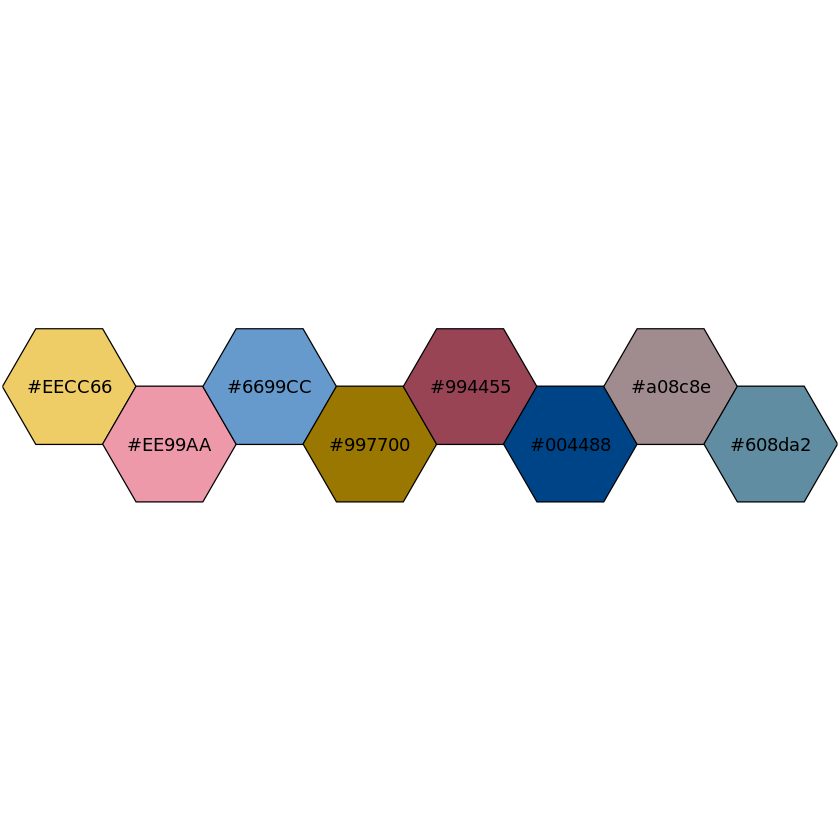

In [5]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [6]:
SPL_AspG_RPM <- readRDS(paste0(INT_SPL, "Asp_genus_RPM.Rdata"))
SPL_AspS_RPM <- readRDS(paste0(INT_SPL, "Asp_species_RPM.Rdata"))
lst_perc_Asp <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp.Rdata"))

classification_table <- read.csv(paste0(INT_ReSeq, "classification_table.csv"))

LOSD_genus_table_withNoise <- readRDS(paste0(INT_LOSD, "LOSD_genus_table_withNoise.Rdata"))
LOSD_species_table_withNoise <- readRDS(paste0(INT_LOSD, "LOSD_species_table_withNoise.Rdata"))

In [100]:
if(exists("RPM_AspG")){rm("RPM_AspG")}
for (n in names(SPL_AspG_RPM)){
    tmp_RPM_AspG <- SPL_AspG_RPM[[n]] %>% 
        melt(varnames = c("db", "sample_id"), value.name = "value") %>%  
        mutate(thrshld = gsub(n, pattern = "conf", replacement = "")) %>% 
        filter(db %in% dbs_sel_min) %>%
        mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                        ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                        ifelse(grepl(sample_id, pattern = "^H"), yes = "External controls", 
                        ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA)))))  %>% 

        mutate(sample_short = str_replace(sample_id, str_sub(sample_id, 1, 3), "")) %>% 
        mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                      ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control")))  %>% 
        mutate(type = ifelse(grepl(sample_id, pattern = "K$"), yes = "ds-cfDNA", 
                      ifelse(grepl(sample_id, pattern = "P$"), yes = "ds-wcDNA", no = "ss-cfDNA"))) %>% 
        mutate(sample_type = paste(sample, type))  %>% 
        mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","External controls", "controls")))  %>% 
        mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                        "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                        "BAL ds-wcDNA")))  %>% 
        mutate(type = fct_relevel(type, c("ss-cfDNA", "ds-cfDNA", "ds-wcDNA"))) %>% 
        filter(origin != "controls") %>% 
        filter(origin != "Internal controls")  %>% 
        mutate(sample_sh = substr(sample_id, 1, 3))  %>% 
        mutate(sample_sh = ifelse(grepl(sample_id, pattern = "VAL"), paste0(sample_sh, "val"), sample_sh)) 
    if(exists("RPM_AspG")){RPM_AspG <- rbind(RPM_AspG, tmp_RPM_AspG)}
    else{RPM_AspG <- tmp_RPM_AspG}
}

In [101]:
ext_cntrl_AspG <- RPM_AspG %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "dREM.260") %>% 
    filter(origin == "External controls") %>% filter(type == "ss-cfDNA") %>% 
    ggplot(aes(x = thrshld, y = value, fill = sample_type)) + 
        #geom_point(position = position_jitterdodge()) +
        geom_boxplot(alpha=0.6) + 
        facet_grid(rows = vars(sample_type)) + 
        ylab("RPM Aspergillus (G)") + xlab("Confidence Threshold") + 
        ggtitle(label = "Genus level", subtitle = "External Controls; dREM.260") + 
        scale_fill_manual(values = c("BAL ss-cfDNA" = colors_mc[3], "plasma ss-cfDNA" = colors_mc[6])) +
        scale_color_manual(values = c("BAL ss-cfDNA" = "darkgrey", "plasma ss-cfDNA" = "black")) +      
        labs(col = "", fill = "") + guides(fill = "none", col = "none")

In [102]:
RPM_AspS <- SPL_AspS_RPM %>% 
    rename(sample = "sample_id") %>% 
    rename(RPM = "value") %>% 
        mutate(thrshld = gsub(threshold, pattern = "conf", replacement = "")) %>% 
        filter(db %in% dbs_sel_min) %>%
        mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                        ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                        ifelse(grepl(sample_id, pattern = "^H"), yes = "External controls", 
                        ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA)))))  %>% 

        mutate(sample_short = str_replace(sample_id, str_sub(sample_id, 1, 3), "")) %>% 
        mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                      ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control")))  %>% 
        mutate(type = ifelse(grepl(sample_id, pattern = "K$"), yes = "ds-cfDNA", 
                      ifelse(grepl(sample_id, pattern = "P$"), yes = "ds-wcDNA", no = "ss-cfDNA"))) %>% 
        mutate(sample_type = paste(sample, type))  %>% 
        mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","External controls", "controls")))  %>% 
        mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                        "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                        "BAL ds-wcDNA")))  %>% 
        mutate(type = fct_relevel(type, c("ss-cfDNA", "ds-cfDNA", "ds-wcDNA"))) %>% 
        filter(origin != "controls") %>% 
        filter(origin != "Internal controls")  %>% 
        mutate(sample_sh = substr(sample_id, 1, 3))  %>% 
        mutate(sample_sh = ifelse(grepl(sample_id, pattern = "VAL"), paste0(sample_sh, "val"), sample_sh)) 

In [103]:
ext_cntrl_AspS <- RPM_AspS %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    filter(db == "cRE.21") %>% 
    mutate(RPM = value*10^6) %>% 
    filter(origin == "External controls") %>% filter(type == "ss-cfDNA") %>% 
    ggplot(aes(x = thrshld, y = RPM, fill = sample_type)) + 
        #geom_point(position = position_jitterdodge()) +
        geom_boxplot(alpha=0.6) + 
        facet_grid(rows = vars(sample_type)) + 
        ylab("RPM Aspergillus (S)") + xlab("Confidence Threshold") + 
        ggtitle(label = "Species level", "External Controls; cRE.21") + 
        scale_fill_manual(values = c("BAL ss-cfDNA" = colors_mc[3], "plasma ss-cfDNA" = colors_mc[6])) +
        scale_color_manual(values = c("BAL ss-cfDNA" = "darkgrey", "plasma ss-cfDNA" = "black")) +      
        labs(col = "", fill = "") + guides(fill = "none", col = "none")

In [104]:
plt_LOSD <- list()
for (j in 1:2){
    plt_LOSD[[j]] <- list(LOSD_species_table_withNoise, LOSD_genus_table_withNoise)[[j]] %>% 
        as.data.frame() %>% 
        melt(id.vars = colnames(.)[!grepl(colnames(.), pattern = "LOSD")], value.name = "LOSD", variable.name = "control_set") %>%
        mutate(M_reads = as.numeric(gsub(control_set, pattern = "[^0-9.-]+", replacement = ""))) %>% 
        filter(M_reads == 70) %>% 
        select(-strain) %>% 
        mutate(sample = ifelse(grepl(control_set, pattern = "_Bctrls"), yes = 'BAL ss-cfDNA', 
                        ifelse(grepl(control_set, pattern = "_Pctrls"), yes = 'plasma ss-cfDNA', NA))) %>% 
        mutate(sample = factor(sample, levels = c('plasma ss-cfDNA', 'BAL ss-cfDNA'))) %>% 
        group_by(LOSD, db, threshold, sample) %>% 
        summarise(n = n(), .groups = "keep") %>% 
        mutate(MPM = factor(LOSD, levels = rev(c(0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,">4096"))))  %>% 
        mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
        mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
        filter(db == c(c("cRE.21", "dREM.260")[j])) %>% 
        ggplot(aes(x = threshold, y = n, fill = MPM)) + 
            geom_col(position = "fill") +
            scale_fill_manual(drop = FALSE, na.value = "black", 
                              breaks = rev(c(0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,">4096")), 
                              values = c(colors_mc[7], browns(5)[1:4], reds(7)[2:7], blues(6)[1:5])) + 
            guides(color = guide_legend(override.aes = list(fill = NA)),
            linetype = guide_legend(override.aes = list(fill = NA))) +
            #scale_color_manual(values = c("BAL ss-cfDNA" = "darkgrey", "plasma ss-cfDNA" = "black")) +
            scale_y_continuous(breaks=c(0,seq(5, 55, 10))) +
            theme_bw() + theme(legend.key = element_rect(fill = "white")) +
            ylab("Fraction Aspergillus simulations") + 
            ggtitle(label = "", subtitle = "LOSD, 70M reads") + 
            facet_grid(cols = vars(db), rows = vars(sample), scales = "free_x") + xlab("Confidence Threshold") + 
            labs(fill = "Molecules\nPer\nMillion (MPM)") 
}

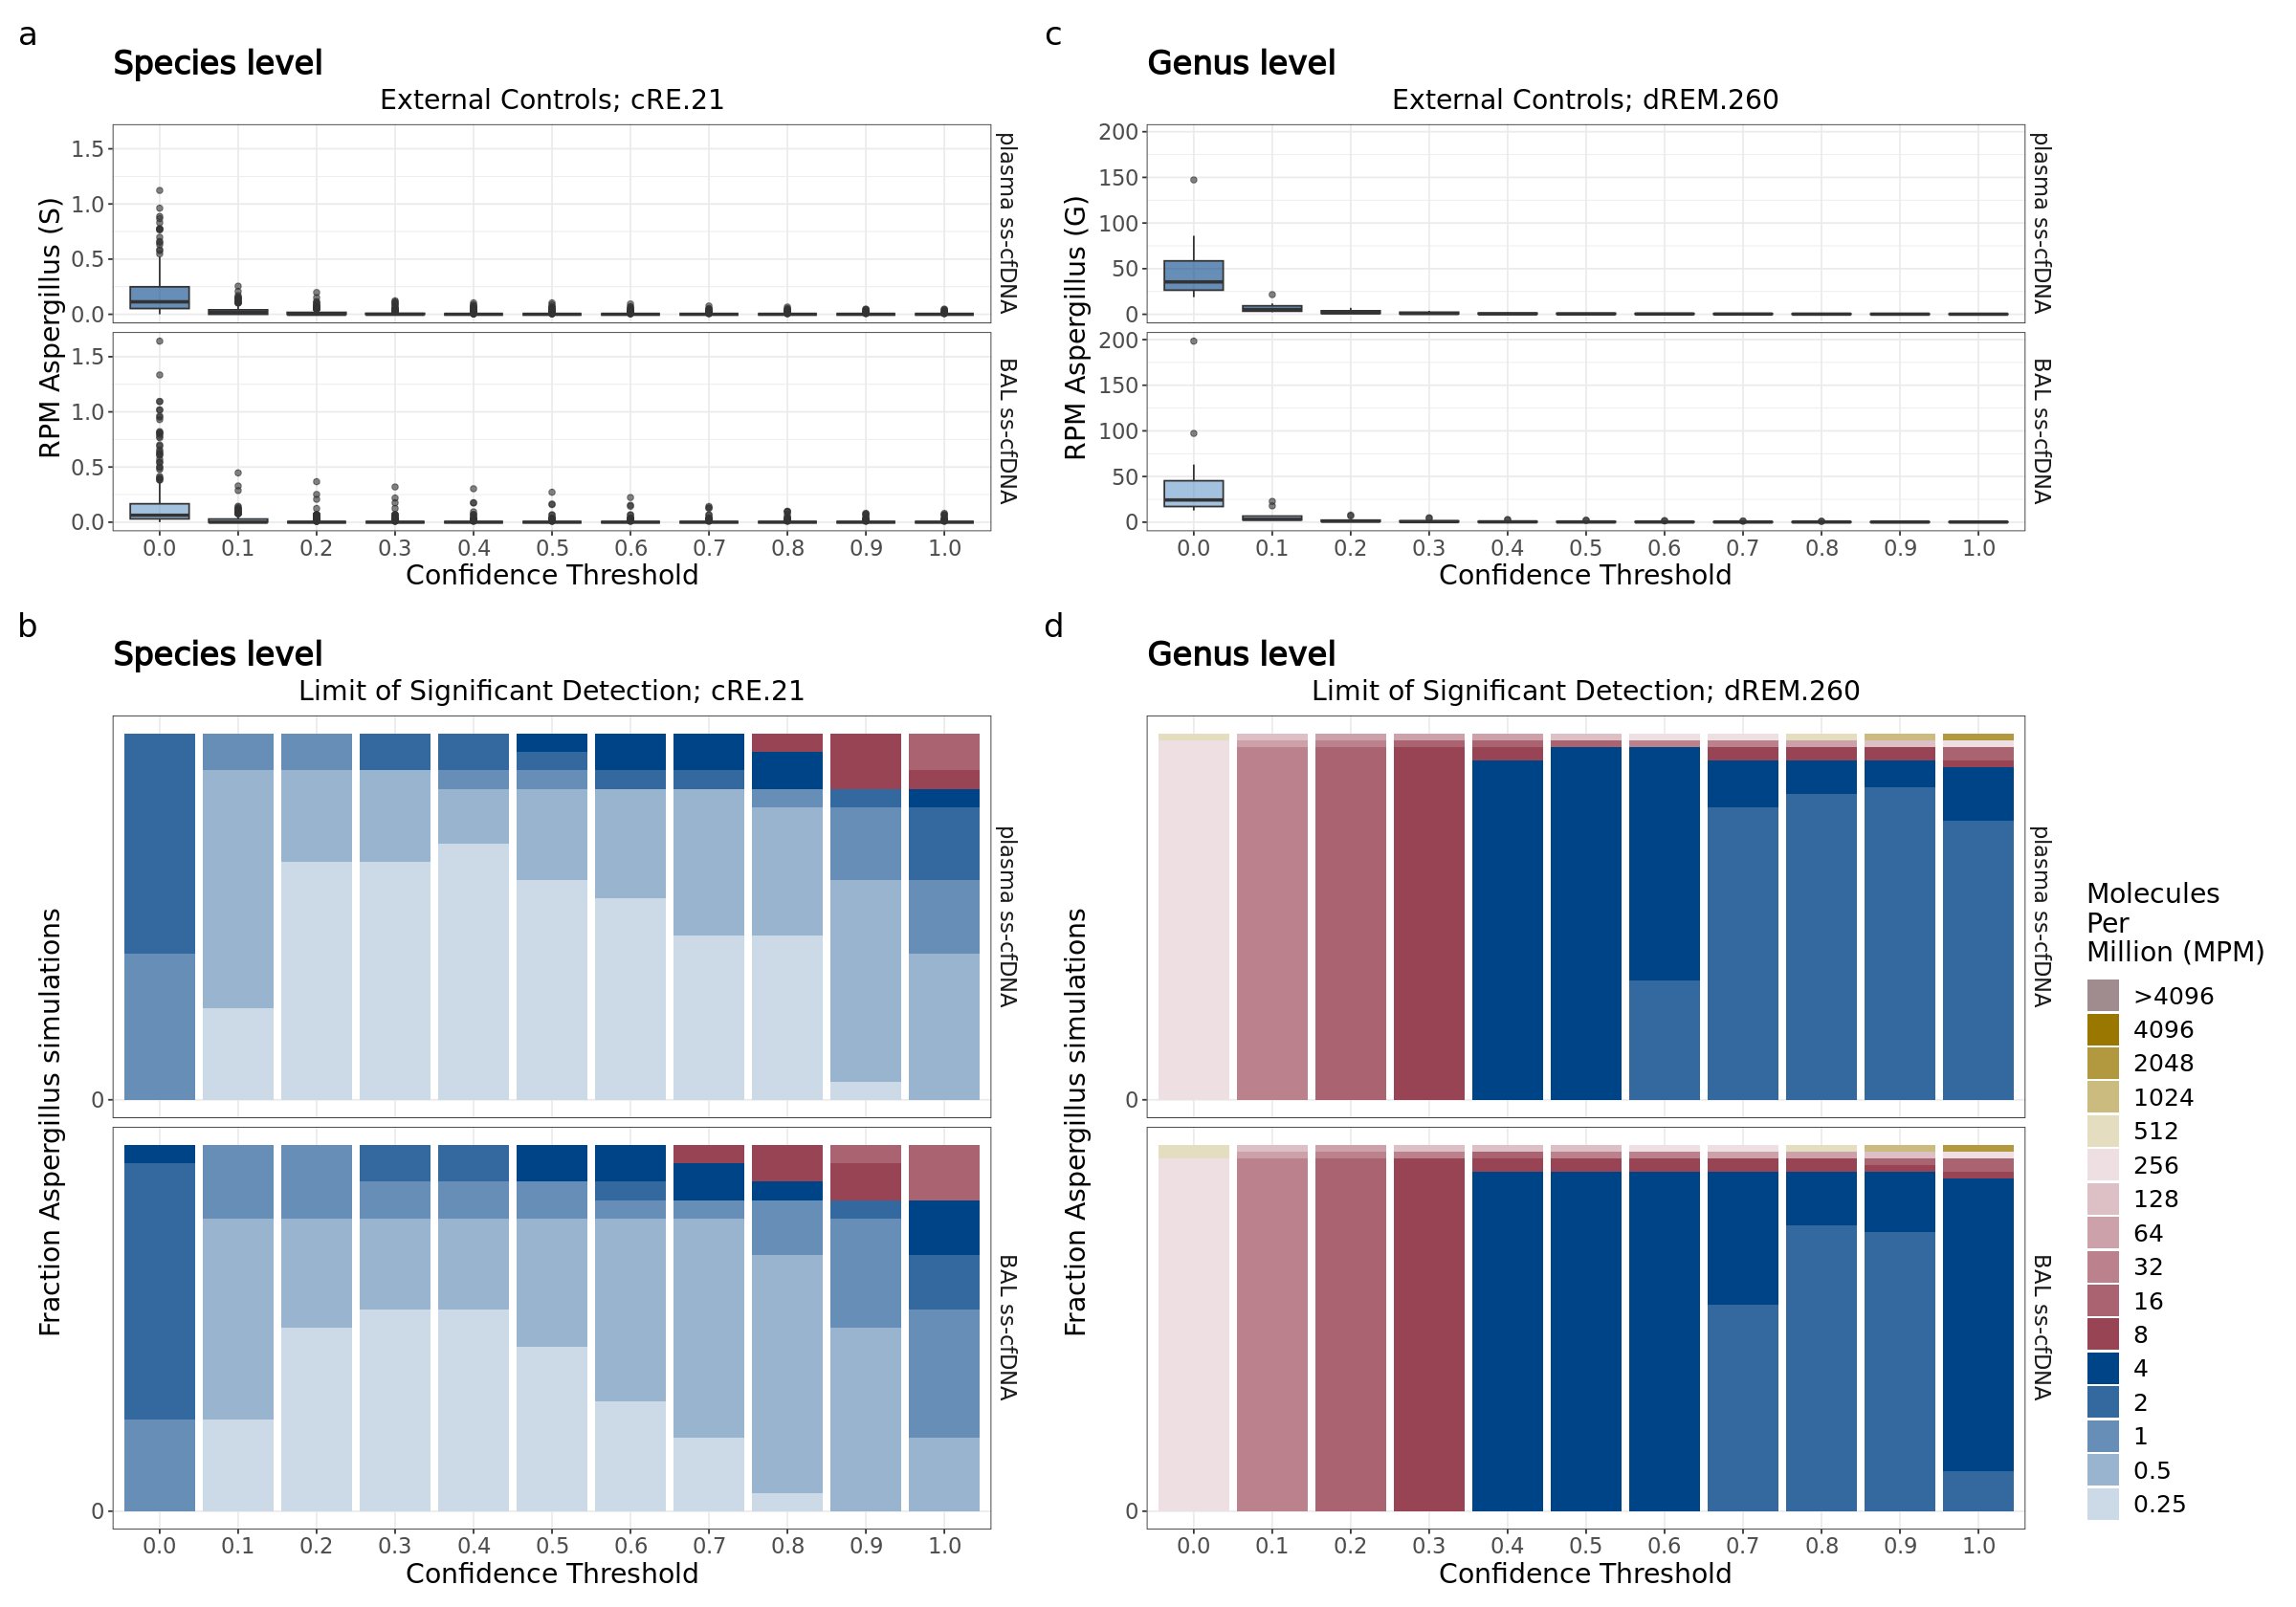

In [105]:
options(repr.plot.width=20, repr.plot.height=14)
layout= "
    AC
    BD"
Fig5 <- 
    (ext_cntrl_AspS + labs(tag = 'a')) +  
    (plt_LOSD[[1]] + labs(tag = 'b') + ggtitle("Species level", subtitle = "Limit of Significant Detection; cRE.21")) +
    (ext_cntrl_AspG + labs(tag = 'c')) +  
    (plt_LOSD[[2]] + labs(tag = 'd') + ggtitle("Genus level", subtitle = "Limit of Significant Detection; dREM.260")) +
        plot_layout(ncol = 2, guides = "collect", design = layout, heights = c(1,2)) &
        guides(size = 30) & 
        theme_bw() &
        theme(legend.position='right', legend.justification='bottom', legend.direction = 'vertical',
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5), 
            strip.text.x = element_blank(), 
            strip.background = element_blank())

Fig5

ggsave("../../output/figures/Fig5_R.png", 
       Fig5, width = 20, height = 14)
ggsave("../../output/figures/Fig5_R.pdf", 
       Fig5, width = 20, height = 14)

In [13]:
###mentioned in results###
###1
RPM_AspG_cRE.21 <- RPM_AspG %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    filter(origin == "External controls") %>% filter(type == "ss-cfDNA") %>% 
    filter(db == "cRE.21") %>% 
    group_by(sample) %>% 
    summarise(mean_value = mean(value, na.rm = TRUE, trim = Inf))
print("cRE.21: ")
round(RPM_AspG_cRE.21$mean_value[which(RPM_AspG_cRE.21$sample=="plasma")]/
    RPM_AspG_cRE.21$mean_value[which(RPM_AspG_cRE.21$sample=="BAL")], digits =1)

RPM_AspG_dREM.260 <- RPM_AspG %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(origin == "External controls") %>% filter(type == "ss-cfDNA") %>% 
    filter(db == "dREM.260") %>% 
    group_by(sample) %>% 
    summarise(mean_value = mean(value, na.rm = TRUE, trim = Inf))
print("dREM.260: ")
round(RPM_AspG_dREM.260$mean_value[which(RPM_AspG_dREM.260$sample=="plasma")]/
    RPM_AspG_dREM.260$mean_value[which(RPM_AspG_dREM.260$sample=="BAL")], digits =1)

###2
LOSD_species_table_withNoise %>% 
    as.data.frame() %>% 
    melt(id.vars = colnames(.)[!grepl(colnames(.), pattern = "LOSD")], value.name = "LOSD", variable.name = "control_set") %>%
    mutate(M_reads = as.numeric(gsub(control_set, pattern = "[^0-9.-]+", replacement = ""))) %>% 
    filter(M_reads == 70) %>% 
    select(-strain) %>% 
    mutate(sample = ifelse(grepl(control_set, pattern = "_Bctrls"), yes = 'BAL ss-cfDNA', 
                    ifelse(grepl(control_set, pattern = "_Pctrls"), yes = 'plasma ss-cfDNA', NA))) %>% 
    mutate(sample = factor(sample, levels = c('plasma ss-cfDNA', 'BAL ss-cfDNA'))) %>% 
    group_by(db, threshold, sample) %>% 
    mutate(LOSD = as.numeric(LOSD)) %>%
    summarise(N = n(), Ns4 = sum(LOSD <= 4), prct = Ns4/N*100, .groups="keep") %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "cRE.21") %>% filter(threshold == 0.4)

LOSD_genus_table_withNoise %>% 
    as.data.frame() %>% 
    melt(id.vars = colnames(.)[!grepl(colnames(.), pattern = "LOSD")], value.name = "LOSD", variable.name = "control_set") %>%
    mutate(M_reads = as.numeric(gsub(control_set, pattern = "[^0-9.-]+", replacement = ""))) %>% 
    filter(M_reads == 70) %>% 
    select(-strain) %>% 
    mutate(sample = ifelse(grepl(control_set, pattern = "_Bctrls"), yes = 'BAL ss-cfDNA', 
                    ifelse(grepl(control_set, pattern = "_Pctrls"), yes = 'plasma ss-cfDNA', NA))) %>% 
    mutate(sample = factor(sample, levels = c('plasma ss-cfDNA', 'BAL ss-cfDNA'))) %>% 
    group_by(db, threshold, sample) %>% 
    mutate(LOSD = as.numeric(LOSD)) %>% 
    summarise(N = n(), Ns4 = sum(LOSD <= 4), prct = Ns4/N*100, .groups="keep") %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "dREM.260") %>% filter(threshold == 0.9)

[1] "cRE.21: "


[1] 1.5

[1] "dREM.260: "


[1] 1.2

db,threshold,sample,N,Ns4,prct
<chr>,<chr>,<fct>,<int>,<int>,<dbl>
cRE.21,0.4,plasma ss-cfDNA,20,20,100
cRE.21,0.4,BAL ss-cfDNA,20,20,100


Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `LOSD = as.numeric(LOSD)`.
ℹ In group 42: `db = "EPRSc2"`, `threshold = "0.9"`, `sample = BAL ss-cfDNA`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


db,threshold,sample,N,Ns4,prct
<chr>,<chr>,<fct>,<int>,<int>,<dbl>
dREM.260,0.9,plasma ss-cfDNA,55,51,92.72727
dREM.260,0.9,BAL ss-cfDNA,55,51,92.72727
